In [1]:
%matplotlib inline
import sys
sys.path.insert(0, './census/')

import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import pandas as pd
import numpy as np
import pickle_data
import census_api
import requests
import json

# Comparing Census API Wrapper to Own Accesses
The following code ensures my census API accesses result in the same output as the
census wrapper API.

In [2]:
# final version
def get_request(year, dataset, columns, preds=[], for_='', in_=''):
    req = (f'https://api.census.gov/data/{year}/{dataset}?get='
           +','.join(columns))
    if len(preds) > 0:
        req += '&'+'&'.join(preds)+'&'
    else:
        req += '&'
    if for_ != '':
        req += f'for={for_}&'
    if in_ != '':
        req += f'in={in_}&'
    req += f'key={census_api.api_key}'
    return req

In [3]:
from census import Census
from us import states

In [4]:
name = 'NAME'
total_families = 'B11004_001E'
married_families = 'B11004_002E'
married_kids_families = 'B11004_003E'

In [5]:
c = Census(census_api.api_key, year=2013)
c_df = pd.read_json(json.dumps(c.acs1.state(('NAME',
                                             total_families,
                                             married_families,
                                             married_kids_families),
                                            Census.ALL)))

In [6]:
req = get_request(2013, 'acs1',
                  [name,
                   total_families,
                   married_families,
                   married_kids_families],
                 for_='state:*')
# print(req)
sauce = requests.get(req)
r_df = pd.read_json(json.dumps(sauce.json()))
r_df.columns = r_df.iloc[0].values
r_df = r_df[1:]
for c in r_df.columns[~r_df.columns.isin([name])]:
    r_df[c] = r_df[c].astype('int64')

In [7]:
print('c_df:')
print(c_df.head())
print('\n\nr_df:')
print(r_df.head())

c_df:
   B11004_001E  B11004_002E  B11004_003E        NAME  state
0      1222568       857865       334703     Alabama      1
1       165431       126502        58480      Alaska      2
2      1572310      1136593       463668     Arizona      4
3       751124       548537       222328    Arkansas      5
4      8645970      6160314      2972140  California      6


r_df:
         NAME  B11004_001E  B11004_002E  B11004_003E  state
1     Alabama      1222568       857865       334703      1
2      Alaska       165431       126502        58480      2
3     Arizona      1572310      1136593       463668      4
4    Arkansas       751124       548537       222328      5
5  California      8645970      6160314      2972140      6


# Accessing Population Data
The following code snippets demonstrate basic statistics with population data obtained from the US Census API.

In [8]:
fips_df = pickle_data.get_pickled_data('./census/fips.pickle')
fips_df.Code = fips_df.Code.astype('int64')
def fips_code(state):
    return fips_df.Code[(fips_df.Name==state) | (fips_df.Abbr==state)].iat[0]

In [9]:
try:
    assert(fips_code('GA')==int(states.GA.fips))
    assert(fips_code('Georgia')==fips_code('GA'))
    print('tests passed')
except AssertionError:
    print('tests did not pass')

tests passed


In [10]:
req = get_request(2014,'pep/natstprc',
                  ['STNAME','POP','DEATHS'],
                  ['DATE=7'], for_='state:*')
# print(req)
sauce = requests.get(req)
pop_df = pd.read_json(json.dumps(sauce.json()))
pop_df.columns = pop_df.iloc[0].values
pop_df = pop_df[1:]
pop_df.state = pop_df.state.astype('float64')
print(pop_df.count())
pop_df = pop_df[pop_df.state.isin(fips_df.Code)]
print(pop_df.count())

STNAME    52
POP       52
DEATHS    52
DATE      52
state     52
dtype: int64
STNAME    51
POP       51
DEATHS    51
DATE      51
state     51
dtype: int64


In [11]:
pop_df

,STNAME,POP,DEATHS,DATE,state
1,Alabama,4849377,49793,7,1.0
2,Alaska,736732,4245,7,2.0
3,Arizona,6731484,51748,7,4.0
4,Arkansas,2966369,29231,7,5.0
5,California,38802500,255787,7,6.0
6,Colorado,5355866,34337,7,8.0
7,Connecticut,3596677,29579,7,9.0
8,Delaware,935614,8278,7,10.0
9,District of Columbia,658893,5228,7,11.0
10,Florida,19893297,187102,7,12.0


# Back to ACS
Now I'll look at the original dataset using matplotlib and seaborn.

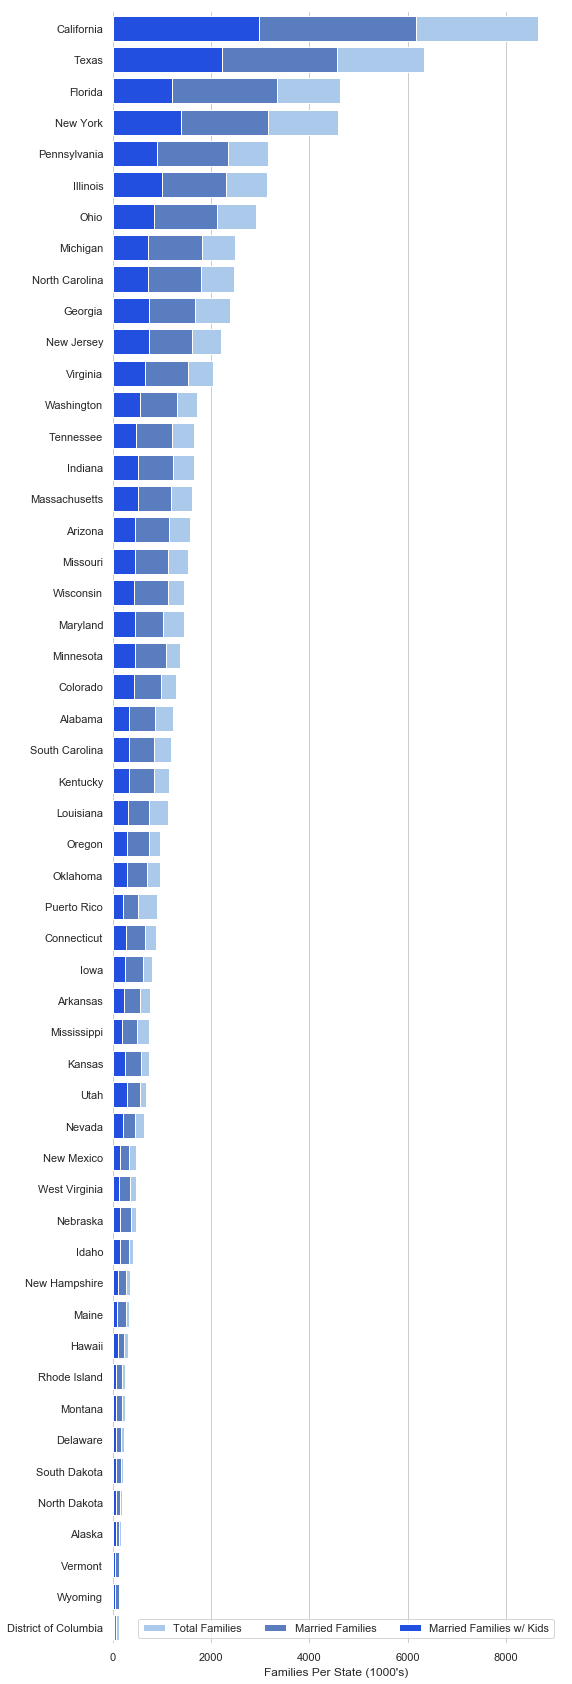

In [12]:
sns.set(style='whitegrid')

fig, ax = plt.subplots(figsize=(8,30))
families = r_df.sort_values(total_families, ascending=False)
families[[total_families, married_families, married_kids_families]] /= 1000

sns.set_color_codes('pastel')
sns.barplot(x=total_families,
            y='NAME',
            data=families,
            label='Total Families',
            color='b')

sns.set_color_codes('muted')
sns.barplot(x=married_families,
            y='NAME',
            data=families,
            label='Married Families',
            color='b')

sns.set_color_codes('bright')
sns.barplot(x=married_kids_families,
            y='NAME',
            data=families,
            label='Married Families w/ Kids',
            color='b')

ax.legend(ncol=3, loc='lower right', frameon=True)
ax.set(xlabel='Families Per State (1000\'s)',
       ylabel = '')
sns.despine(left=True, bottom=True, top=True)

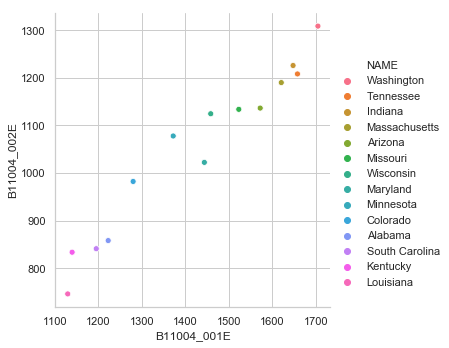

In [13]:
sns.set_color_codes('pastel')
sns.relplot(x=total_families, y=married_families, hue='NAME',
            data=families[12:26])

In [14]:
families.mean()[:3]

B11004_001E    1491.837365
B11004_002E    1083.993538
B11004_003E     461.900750
dtype: float64

In [15]:
families.std()[:3]

B11004_001E    1620.435807
B11004_002E    1157.730739
B11004_003E     535.095740
dtype: float64

In [16]:
families.median()[:3]

B11004_001E    1045.3170
B11004_002E     738.6975
B11004_003E     306.2175
dtype: float64

In [17]:
families.mode()[:3]

,NAME,B11004_001E,B11004_002E,B11004_003E,state
0,Alabama,120.467,65.805,26.854,1
1,Alaska,148.556,118.017,42.687,2
2,Arizona,155.933,123.176,48.631,4


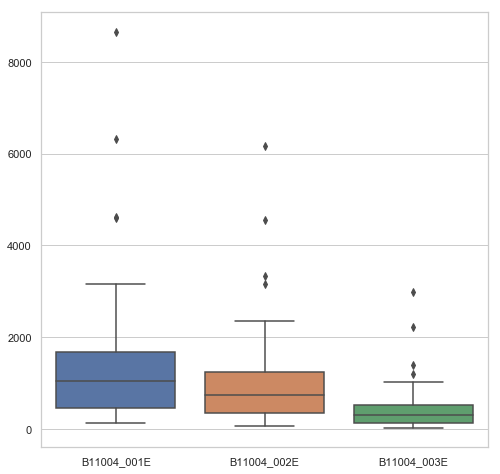

In [18]:
plt.subplots(figsize=(8,8))
sns.boxplot(data=families[[total_families,
                           married_families, 
                           married_kids_families]])

# More Seaborn Features
The code below is mainly to highlight seaborn's lineplot functionality.

In [19]:
ga = fips_code('GA')
req = get_request(1990,'pep/int_charagegroups',
                  ['AGEGRP','RACE_SEX','HISP','POP'],
                  for_='county:*', in_=f'state:{ga}')
# print(req)
sauce = requests.get(req)
pop_df2 = pd.read_json(json.dumps(sauce.json()))
pop_df2.columns = pop_df2.iloc[0].values
pop_df2 = pop_df2[1:]

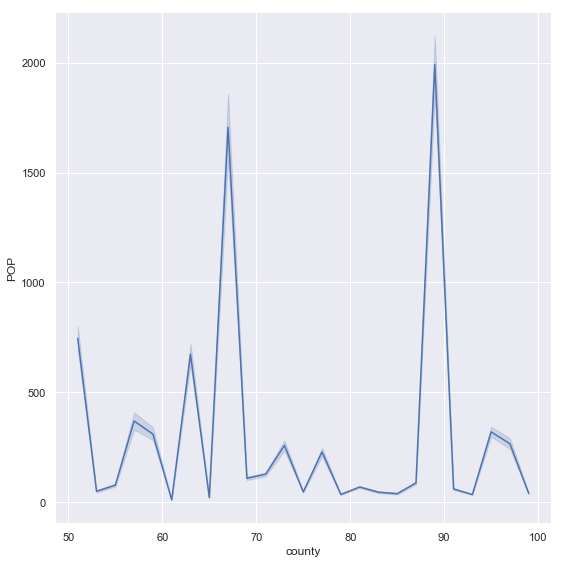

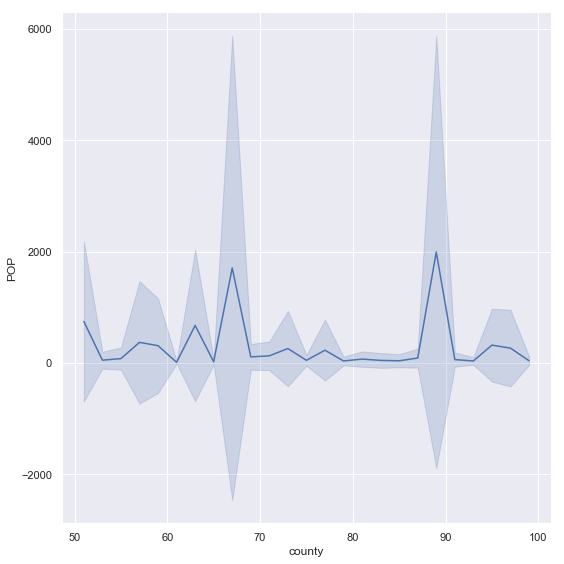

In [20]:
sns.set(style='darkgrid')
pop_df2.POP = pop_df2.POP.astype('int64')
pop_df2.state = pop_df2.state.astype('int64')
pop_df2.county = pop_df2.county.astype('int64')
pop_df2 = pop_df2[(50 < pop_df2.county) & (pop_df2.county < 100)]
sns.relplot(x='county', y='POP', kind='line', height=8, data=pop_df2)
sns.relplot(x='county', y='POP', kind='line', ci='sd', height=8, data=pop_df2)

# No More Seaborn Focus

In [21]:
cols = [f'EXPALL20{i}' for i in
        ['08','09','10','11','12','13','14','15','16','17']]
req = get_request(2017,'intltrade/imp_exp', cols+['COUNTRY'])
sauce = requests.get(req)
trade_df = pd.read_json(json.dumps(sauce.json()))
trade_df.columns = trade_df.iloc[0].values
trade_df = trade_df[1:]
trade_df.drop(columns=['COUNTRY'], inplace=True)
trade_df.fillna(value=0, inplace=True)
#trade_df.dropna(inplace=True)
for c in trade_df.columns:
    trade_df[c] = trade_df[c].astype('int64', errors='ignore')

In [22]:
trade_df_new = trade_df.copy(deep=True)
trade_df_new.loc['Total'] = trade_df.sum()
total = trade_df_new.loc['Total']

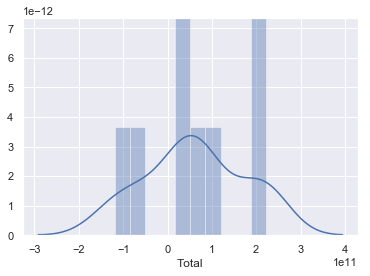

In [23]:
sns.distplot(total.diff()[2:], bins=10)

In [24]:
print(total.diff()[2:].std())
print(total.diff()[2:].mean())

115948840657.7632
61535726001.625


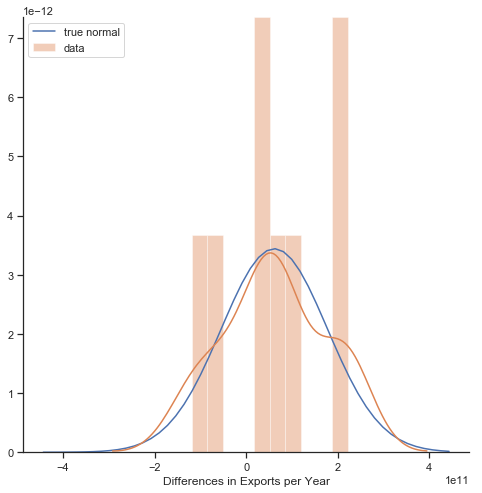

In [25]:
sns.set(style='ticks')
fig, ax = plt.subplots(figsize=(8,8))
x = max(abs(min(total.diff()[2:]*2)), abs(max(total.diff()[2:]*2)))
xs = np.linspace(-x, x)

sns.lineplot(xs, stats.norm.pdf(xs, total.diff()[2:].mean(),
                            total.diff()[2:].std()), label='true normal')
sns.distplot(total.diff()[2:], bins=10, label='data')

ax.legend(loc='upper left', frameon=True)
ax.set(xlabel='Differences in Exports per Year',
       ylabel = '')
sns.despine()

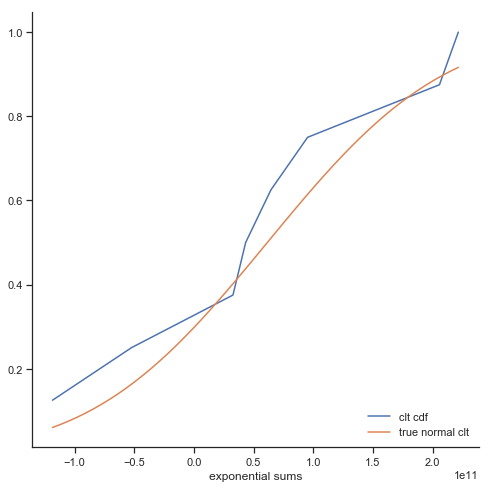

In [26]:
total_diff = total.diff()[2:]
total_pmf = (total_diff.value_counts().sort_index()
             / len(total_diff))
total_cdf = total_pmf.cumsum()

fig, ax = plt.subplots(figsize=(8,8))
xs = np.linspace(min(total_diff), max(total_diff))
sns.lineplot(data=total_cdf, label='clt cdf')
sns.lineplot(xs, stats.norm.cdf(xs, total_diff.mean(), total_diff.std()),
             label='true normal clt')
ax.legend(loc='lower right', frameon=False)
ax.set(xlabel='exponential sums')
sns.despine()